In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil
from itertools import chain
from scipy.stats import skew

from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [5]:
df_train = pd.read_csv('../data/cleaned/train.csv', index_col='id')
df_test = pd.read_csv('../data/cleaned/test.csv', index_col='id')

df_train['ms_subclass'] = df_train['ms_subclass'].astype('object')
df_test['ms_subclass'] = df_test['ms_subclass'].astype('object')

obj_cols = df_train.select_dtypes(['object']).columns
num_cols = df_train.drop('saleprice',1).select_dtypes(exclude=['object']).columns

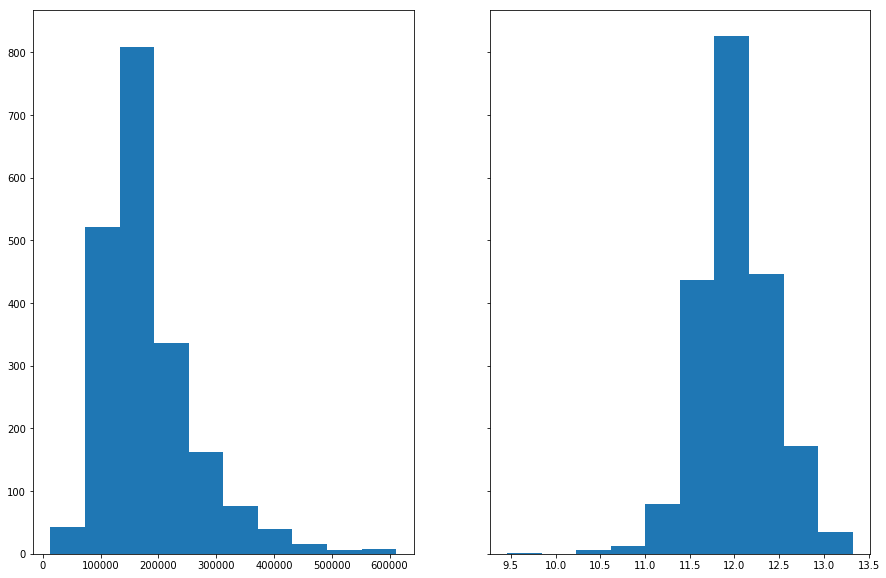

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharey=True)
ax[0].hist(df_train['saleprice'])
ax[1].hist(np.log1p(df_train['saleprice']));

The `np.log1p` function returns the log of $1 + $`saleprice`, which nicely deskews the saleprice as shown above.

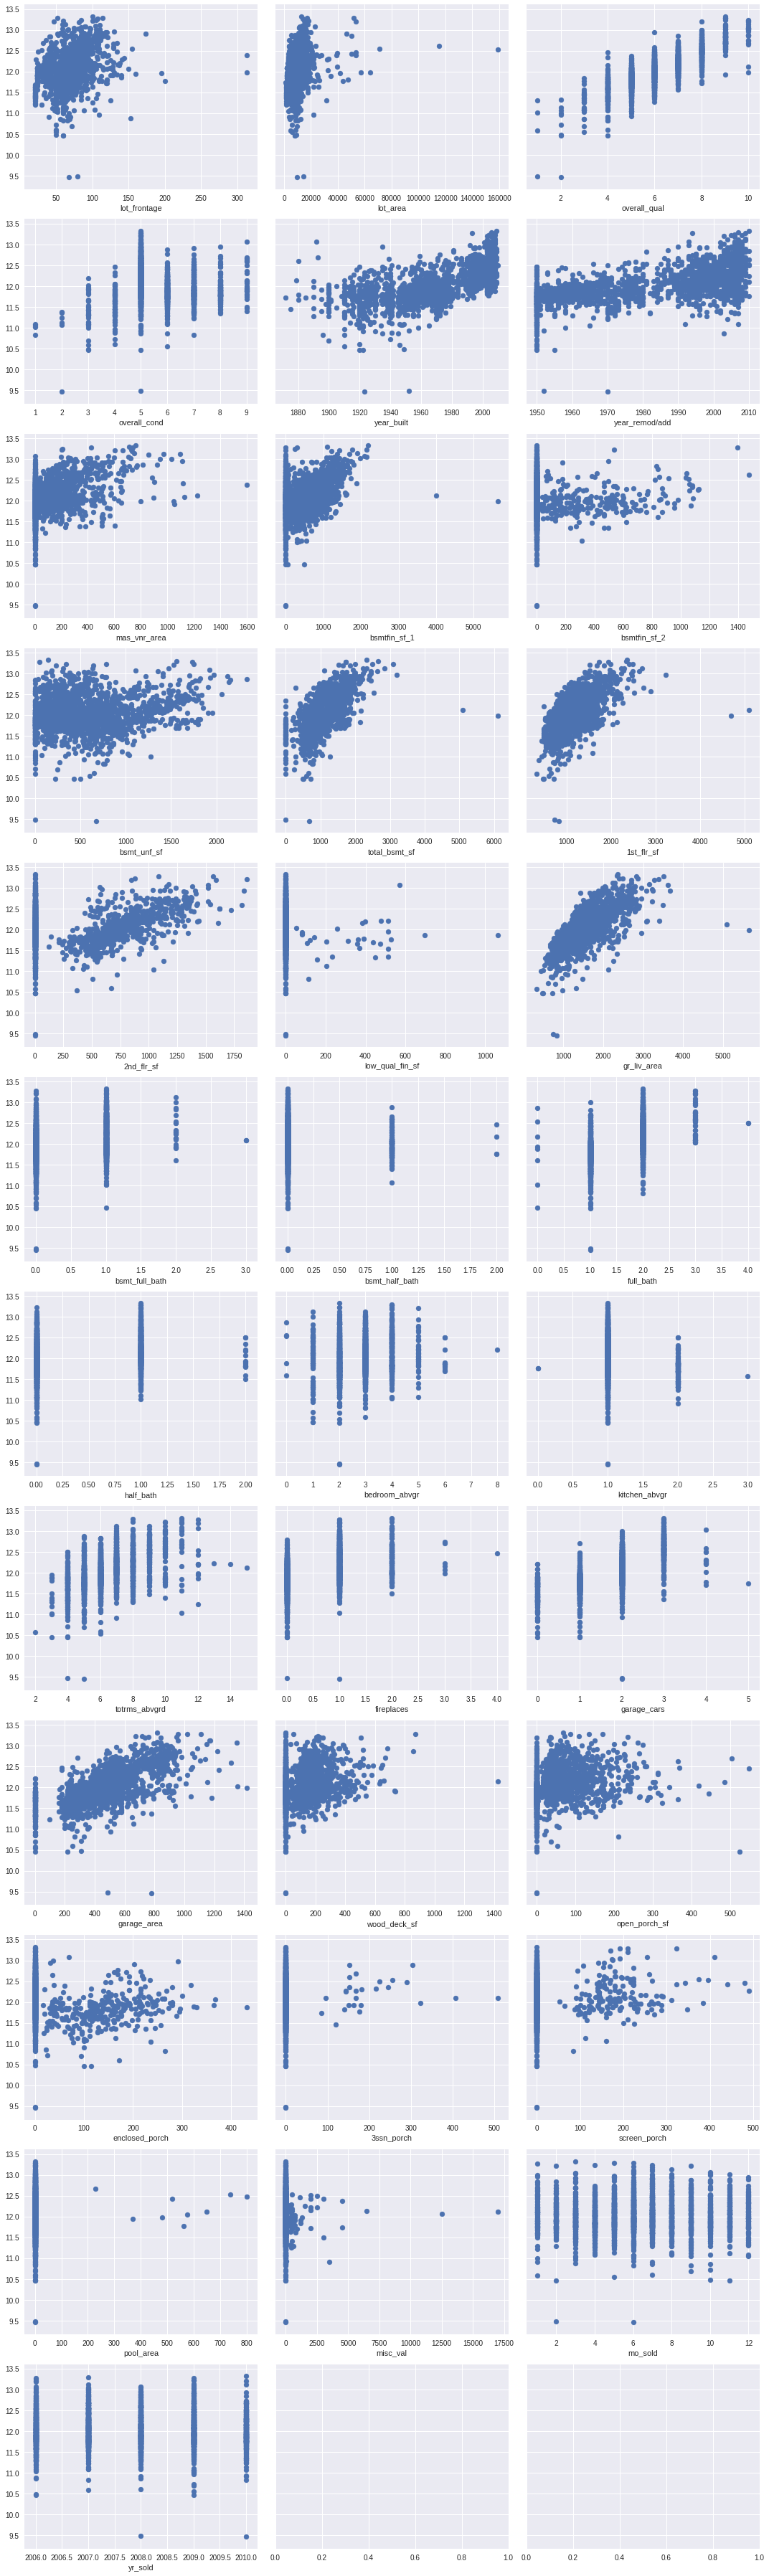

In [4]:
fig, ax = plt.subplots(nrows=ceil(len(num_cols)/3), ncols=3, figsize=(15,50), sharey=True)
iter_ax = chain(*ax)
for col in num_cols:
    cur_ax = next(iter_ax)
    cur_ax.scatter(df_train[col], np.log1p(df_train['saleprice']))
    cur_ax.set_xlabel(col)
plt.tight_layout()

I'm going to drop a bunch of the numerical columns based on the lack of a visual linear relationship between the feature and sale price.

In [5]:
num_cols_drop = [
'lot_frontage',
'lot_area',
'bsmtfin_sf_2',
'bsmt_unf_sf',
'low_qual_fin_sf',
'bedroom_abvgr',
'kitchen_abvgr',
'bsmt_full_bath',
'bsmt_half_bath',
'half_bath',
'3ssn_porch',
'screen_porch',
'pool_area',
'misc_val',
'mo_sold',
'yr_sold'
]

num_cols = [col for col in num_cols if col not in num_cols_drop]
df_train.drop(labels=num_cols_drop, axis=1, inplace=True)
df_test.drop(labels=num_cols_drop, axis=1, inplace=True)

We have a few columns with high skew, we'll try to correct for that in the same way we did the saleprice, with the log transform.

In [6]:
skew_cols = df_train[num_cols].apply(skew)
for col in num_cols:
    if abs(skew_cols[col]) > .5:
        tmp_col = np.log1p(df_train[col])
        
        if abs(skew(tmp_col)) < abs(skew_cols[col]):
            df_train[col] = tmp_col
            df_test[col] = np.log1p(df_test[col])

I'm going to set a variance threshold that only keeps the top $30$ of the $300$ features generated by converting the categorical features to dummy variables.

In [7]:
obj_dum_train = pd.get_dummies(df_train[obj_cols])
obj_dum_test = pd.get_dummies(df_test[obj_cols])

cols_to_keep = obj_dum_train.apply(np.var).sort_values(ascending=False).index[:30]

obj_dum_train = obj_dum_train[cols_to_keep]
obj_dum_test = obj_dum_test[cols_to_keep]

In [8]:
df_train = df_train[num_cols + ['saleprice']].join(obj_dum_train)
df_test = df_test[num_cols].join(obj_dum_test)

In [9]:
df_train.to_csv('../data/engineered/train.csv')
df_test.to_csv('../data/engineered/test.csv')